In [1]:
import numpy as np
from numpy.linalg import inv
from sklearn.preprocessing import normalize
from scipy.optimize import linprog
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def heatmap(a):

    plt.imshow(a, cmap='gray', interpolation='nearest')
    plt.show()

In [3]:

gamma = 0.9

In [4]:

w, h = 10, 10
grid = np.zeros((w, h))
n = grid.size
S = np.eye(n, n)

In [5]:
# Actions
k = 5
A = np.eye(k)
UP, DOWN, RIGHT, LEFT, NOOP = 0, 1, 2, 3, 4

In [6]:

P = np.zeros((k, n, n))

mask = np.zeros((k, n))
grid.fill(1)
grid[0,:] = 0
mask[UP] = grid.reshape(-1)
grid.fill(1)
grid[-1,:] = 0
mask[DOWN] = grid.reshape(-1)
grid.fill(1)
grid[:,-1] = 0
mask[RIGHT] = grid.reshape(-1)
grid.fill(1)
grid[:,0] = 0
mask[LEFT] = grid.reshape(-1)


move = np.zeros((k, n, n))
move[UP]    = np.roll(S, shift=-w, axis=0) * mask[UP]
move[DOWN]  = np.roll(S, shift=+w, axis=0) * mask[DOWN]
move[RIGHT] = np.roll(S, shift=+1, axis=0) * mask[RIGHT]
move[LEFT]  = np.roll(S, shift=-1, axis=0) * mask[LEFT]

directions = [UP, DOWN, RIGHT, LEFT]
for d in directions:
    # First build the random diffusion
    P[d] += sum([ move[x] for x in directions if x != d ])
    # Normalize random diffusion and multiply it by 30%
    P[d] = normalize(P[d], axis=0, norm='l1') * 0.3
    # Add the main direction
    P[d] += move[d] * 0.7
    # Renormalize for cells in which random diffusion was 0
    P[d] = normalize(P[d], axis=0, norm='l1')

P[NOOP] = np.eye(n)


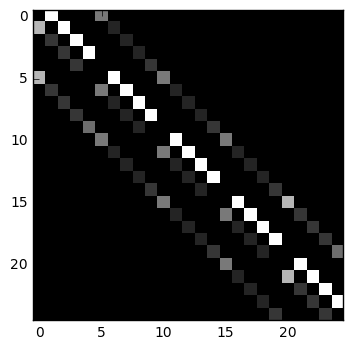

In [7]:

heatmap(P[UP])

In [8]:

grid.fill(0)
grid[0,-1] = 1
R = grid.reshape(-1)
Rmax = 1.0

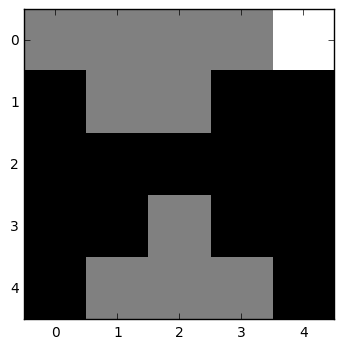

In [9]:

policy = np.array([
    [RIGHT, RIGHT, RIGHT, RIGHT, NOOP],
    [UP,    RIGHT, RIGHT, UP,    UP  ],
    [UP   , UP   , UP   , UP   , UP  ],
    [UP   , UP   , RIGHT, UP   , UP  ],
    [UP   , RIGHT, RIGHT, RIGHT, UP  ],
]).reshape(-1)

heatmap(policy.reshape(w, h))

In [10]:

I = np.eye(n)
nR = np.ndarray(n)
J = np.ndarray((k, n, n))
for a in range(k):
    J[a] = inv(I - gamma * P[a])

tr = np.transpose
nb_constraints = n * k * (k - 1) + n * (k - 1)
A = np.zeros((nb_constraints, 2 * n))
cursor = 0
for ai in range(k):
    for aj in range(k):
        if ai == aj:
            continue
        A[cursor:cursor + n, 0:n] = tr(P[ai] - P[aj]).dot(tr(J[ai]))
        cursor += n

for i in range(n):
    a1 = policy[i]
    for a in range(k):
        if a == a1:
            continue
        A[cursor, 0:n] = tr(P[a1, :, i] - P[a, :, i]).dot(tr(J[a1]))
        A[cursor, n + i] = -1
        cursor += 1

b = np.zeros(nb_constraints)

lamb = 10000.
c = np.ndarray(2 * n)
c[:n] = -lamb
c[n:] = 1



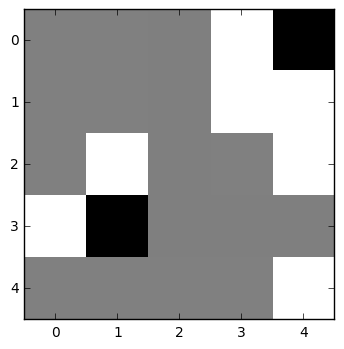

In [11]:
bounds = np.array( [(-Rmax, 0) for i in range(n)] + [(-1000000, 1000000) for i in range(n)] )

res = linprog(c, A, b, bounds=bounds)
heatmap(-res['x'][:n].reshape(w, h))


In [12]:
a = np.zeros((70,))
b = np.zeros((70,))

for i in range(70):
    a[i] = i//10
    b[i] = i%10

print a
print b


print tuple((a[69],b[69]))

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.  0.  1.  2.  3.  4.  5.  6.  7.
  8.  9.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.  0.  1.  2.  3.  4.  5.
  6.  7.  8.  9.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.  0.  1.  2.  3.
  4.  5.  6.  7.  8.  9.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
(6.0, 9.0)
